# Attention Monitoring

Performed image and video classification with a Convolutional Neural Network in Python using TensorFlow Keras.
- Fine-tuned the top layers of a [ResNet-152](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/ResNet152) model pre-trained with the [ImageNet](https://image-net.org/) dataset.
- Used that model to classify video clips and live video feed.

<img align="left" src="notebook_pics/structure.png">

<p><a name="sections"></a></p>

## Sections
- <a href="#Data">Data</a><br>
- <a href="#Data Pre-processing">Data Pre-processing</a><br>
- <a href="#Transfer Learning">Transfer Learning: Fine Tuning</a><br>
    - <a href="#Load and Modify">Load and Modify</a><br>
    - <a href="#Training">Training</a><br>
    - <a href="#Re-training">Re-training</a><br>
- <a href="#Glimpse">A Glimpse into the CNN</a><br>
- <a href="#Video Classification">Video Classification</a><br>
- <a href="#Results">Results</a><br>

<p><a name="Data"></a></p>

## Data
I compiled, labeled and split the images myself. 
- 10427 images in total.
    - Attentive: 5318 
    - Not Attentive: 5109 
- Roughly a 70-15-15 split among the training, validating, and testing sets.
    - Train: 7302
    - Validate: 1561
    - Test: 1564
    

In [1]:
# Construct the path
DATA_PATH = "data"
TRAIN_PATH = f'{DATA_PATH}/train/'
VALID_PATH = f'{DATA_PATH}/valid/'
TEST_PATH = f'{DATA_PATH}/test/'

<p><a name="Data Pre-processing"></a></p>

## Data Pre-processing
- Renamed and coverted all images to .jpg format using the application IrFan View.
- The steps for getting it into the network via the `ImageDataGenerator` class are roughly:
    - Read the picture files.
    - Decode the .jpg content to RBG grids of pixels.
    - Convert these into floating point tensors.
    - Rescale the pixel values (between 0 and 255) to the [0, 1] interval as neural networks prefer to deal with small input values and augment the data.
    
Data augmentation is done to create more diversity among the data set so the model is more generalizable. 

I chose to resize the images to 224x224 simply for consistency since most ImageNet CNNs are trained on 224x224 resolution images. However, it is not necessary as CNNs can accept [any input size](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160147).

The *class_mode* is binary because determining whether a person is attentive or not attentive is a binary classification problem. 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_width = 224
image_height = 224
image_size = (image_width, image_height)

# 32 images will be processed at a time
batch_size = 32 

# Initialize training generator
train_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=15,
      width_shift_range=0.15,
      height_shift_range=0.15,
      zoom_range=0.15,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=batch_size,
        class_mode='binary')

# Initialize validation generator
validation_datagen = ImageDataGenerator(rescale=1.0/255) # we only need to scale the input for validation set
validation_generator = validation_datagen.flow_from_directory(
        VALID_PATH,  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=batch_size,
        class_mode='binary')

# Initialize testing generator
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
        TEST_PATH,  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=batch_size,
        class_mode='binary')


Found 7302 images belonging to 2 classes.
Found 1561 images belonging to 2 classes.
Found 1564 images belonging to 2 classes.


- We can gain an idea of how the training images will look: 

Found 7302 images belonging to 2 classes.


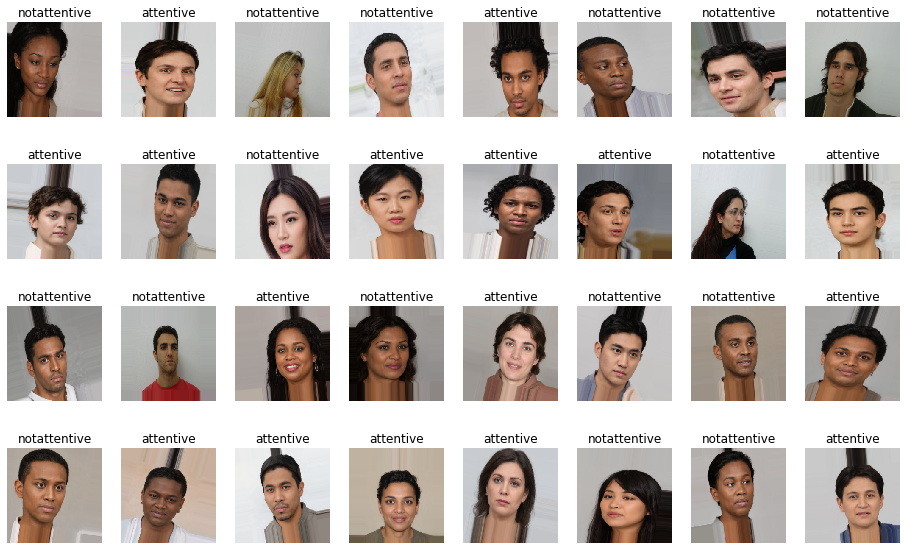

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=15,
      width_shift_range=0.15,
      height_shift_range=0.15,
      zoom_range=[1,1.5],
      fill_mode='nearest')
data_generator = datagen.flow_from_directory(
        TRAIN_PATH,  
        target_size=image_size,  
        batch_size=batch_size,
        class_mode='binary')

x, y = data_generator.next()

plt.figure(figsize=(16, 10))
for i, (img, label) in enumerate(zip(x, y)):
    plt.subplot(4, 8, i+1)
    if label == 1:
        plt.title('notattentive')
    else:
        plt.title('attentive') # automatically labeled zero (subdirectories are labeled in alphabetical order)
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

<p><a name="Transfer Learning"></a></p>

## Transfer Learning: Fine-Tuning

<p><a name="Load and Modify"></a></p>

### Load and Modify
Using a CNN pre-trained on a very large dataset, such as ImageNet, would yield much better results than training the CNN myself on a much more limited dataset. 
ResNet-152 was chosen due to better performance compared to other architectures. Its deepness is a big contributor to its effectiveness. ResNet-152 is trained on a subset of the ImageNet dataset consisting of 1.2 million images with 1000 categories.

Paper: https://arxiv.org/abs/1512.03385

In [4]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model

# Load the ResNet152 model without the top fully-connected layers 
# since I will construct my own.
conv_base = ResNet152V2(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [5]:
# The new head of the ResNet network
res_model = conv_base.output
res_model = MaxPooling2D((3, 3))(res_model)
res_model = Flatten()(res_model)
res_model = Dense(512, activation="relu")(res_model)
res_model = Dropout(0.5)(res_model)
res_model = Dense(1, activation='sigmoid')(res_model)

# Combine the ResNet model with its new head
model = Model(inputs=conv_base.input, outputs=res_model)


In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

- In order to benefit from the pre-training the convolutional base must be kept as-is. The base layers are frozen, preventing their weights from getting updated duing training. Only the new head is trained.

In [7]:
# Shows which layers in the base model are trainable
for i, layer in enumerate(conv_base.layers, 1):
    print(f"{i}: {layer}: \n{layer.trainable}\n")

1: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001A2AD6DE280>: 
True

2: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001A2AD396370>: 
True

3: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001A2AD396A30>: 
True

4: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001A2AD396700>: 
True

5: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001A2AD452430>: 
True

6: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001A2AD4625B0>: 
True

7: <tensorflow.python.keras.layers.core.Activation object at 0x000001A2AD452D00>: 
True

8: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001A2AD5921C0>: 
True

9: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001A2AD3FA220>: 
True

10: <tensorflow.python.keras.layers.core.Activation object at 0x000001A2AD5928E0>: 
True

11: <tensorflow.python.

In [8]:
# Freezes the layers in the base model
for layer in conv_base.layers:
    layer.trainable = False

In [9]:
# Again shows which layers in the base model are trainable
for i, layer in enumerate(conv_base.layers, 1):
    print(f"{i}: {layer}: \n{layer.trainable}\n")

1: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001A2AD6DE280>: 
False

2: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001A2AD396370>: 
False

3: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001A2AD396A30>: 
False

4: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001A2AD396700>: 
False

5: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001A2AD452430>: 
False

6: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001A2AD4625B0>: 
False

7: <tensorflow.python.keras.layers.core.Activation object at 0x000001A2AD452D00>: 
False

8: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001A2AD5921C0>: 
False

9: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001A2AD3FA220>: 
False

10: <tensorflow.python.keras.layers.core.Activation object at 0x000001A2AD5928E0>: 
False

11: <tensorfl

<p><a name="Training"></a></p>

### Training
**Callbacks** are defined in order to mitigate overfitting by training for the optimal number of epochs and ensuring that the best model that results in the highest accuracy is saved. 

I run TensorBoard, TensorFlow's visualization toolkit in order to view live visual metrics.

In [9]:
# NOTE: This first model was trained with the following augmentation parameters:
#       rescale=1.0/255,
#       rotation_range=40,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=True,
#       fill_mode='nearest'
#
# The second trained model was trained with the parameters as seen above.

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
%load_ext tensorboard
%tensorboard --logdir './resnet152v2/logs'
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
best_model = ModelCheckpoint("./resnet152v2/attentions_resnet152v2.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
stop_early = EarlyStopping(monitor='val_loss', patience = 50, verbose=1, mode='min', restore_best_weights=True)

history = model.fit(
            train_generator,
            steps_per_epoch=None, 
            validation_steps=None, 
            epochs=200, 
            validation_data=validation_generator,
            callbacks=[best_model, stop_early, TensorBoard(log_dir='./resnet152v2/logs')])

Reusing TensorBoard on port 6006 (pid 29404), started 1 day, 0:28:00 ago. (Use '!kill 29404' to kill it.)

C:\Users\Tyrone\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/200
229/229 [==============================] - 1546s 7s/step - loss: 1.0019 - accuracy: 0.6845 - val_loss: 0.5148 - val_accuracy: 0.7136

Epoch 00001: val_accuracy improved from -inf to 0.71365, saving model to ./resnet152v2\attentions_resnet152v2.h5
Epoch 2/200
229/229 [==============================] - 1492s 7s/step - loss: 0.5112 - accuracy: 0.7399 - val_loss: 0.5157 - val_accuracy: 0.7034

Epoch 00002: val_accuracy did not improve from 0.71365
Epoch 3/200
229/229 [==============================] - 1492s 7s/step - loss: 0.4907 - accuracy: 0.7462 - val_loss: 0.4750 - val_accuracy: 0.7406

Epoch 00003: val_accuracy improved from 0.71365 to 0.74055, saving model to ./resnet152v2\attentions_resnet152v2.h5
Epoch 4/200
229/229 [==============================] - 1486s 6s/step - loss: 0.4891 - accuracy: 0.7495 - val_loss: 0.5154 - val_accuracy: 0.7021

Epoch 00004: val_accuracy did not improve from 0.74055
Epoch 5/200
229/229 [==============================] - 1489s 7s/step - loss: 


Epoch 00079: val_accuracy did not improve from 0.77194
Epoch 80/200
229/229 [==============================] - 1481s 6s/step - loss: 0.3972 - accuracy: 0.7973 - val_loss: 0.4268 - val_accuracy: 0.7585

Epoch 00080: val_accuracy did not improve from 0.77194
Epoch 81/200
229/229 [==============================] - 1482s 6s/step - loss: 0.4031 - accuracy: 0.7929 - val_loss: 0.4227 - val_accuracy: 0.7630

Epoch 00081: val_accuracy did not improve from 0.77194
Epoch 82/200
229/229 [==============================] - 1483s 6s/step - loss: 0.4074 - accuracy: 0.7954 - val_loss: 0.4231 - val_accuracy: 0.7751

Epoch 00082: val_accuracy improved from 0.77194 to 0.77514, saving model to ./resnet152v2\attentions_resnet152v2.h5
Epoch 83/200
229/229 [==============================] - 1487s 6s/step - loss: 0.4007 - accuracy: 0.7966 - val_loss: 0.4168 - val_accuracy: 0.7546

Epoch 00083: val_accuracy did not improve from 0.77514
Epoch 84/200
229/229 [==============================] - 1514s 7s/step - los


Epoch 00119: val_accuracy did not improve from 0.77707
Epoch 120/200
229/229 [==============================] - 1289s 6s/step - loss: 0.3902 - accuracy: 0.8084 - val_loss: 0.4312 - val_accuracy: 0.7681

Epoch 00120: val_accuracy did not improve from 0.77707
Epoch 121/200
229/229 [==============================] - 1290s 6s/step - loss: 0.3902 - accuracy: 0.8017 - val_loss: 0.4193 - val_accuracy: 0.7675

Epoch 00121: val_accuracy did not improve from 0.77707
Epoch 122/200
229/229 [==============================] - 1297s 6s/step - loss: 0.3971 - accuracy: 0.7977 - val_loss: 0.4170 - val_accuracy: 0.7668

Epoch 00122: val_accuracy did not improve from 0.77707
Epoch 123/200
229/229 [==============================] - 1302s 6s/step - loss: 0.3931 - accuracy: 0.8047 - val_loss: 0.4419 - val_accuracy: 0.7700

Epoch 00123: val_accuracy did not improve from 0.77707
Epoch 124/200
229/229 [==============================] - 1287s 6s/step - loss: 0.3957 - accuracy: 0.7969 - val_loss: 0.4268 - val_ac

229/229 [==============================] - 1300s 6s/step - loss: 0.3681 - accuracy: 0.8135 - val_loss: 0.4349 - val_accuracy: 0.7694

Epoch 00200: val_accuracy did not improve from 0.77707


Doesn't seem like the model restored the best weights...

In [10]:
# I save the final model to disk
model.save("./resnet152v2/model", save_format="h5")

- The loss and accuracy of the model over the training and validation data during training are plotted, and the plots are saved:

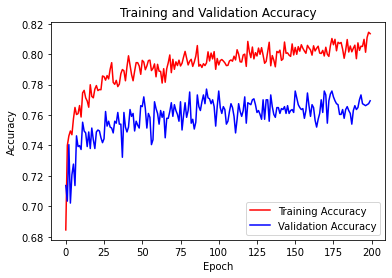

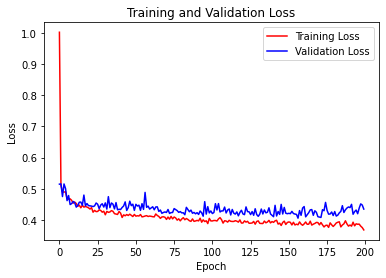

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('graphs/Accuracy1.jpg')
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('graphs/Loss1.jpg')

plt.show()

- The model is evaluated against the test data.

In [12]:
test_loss, test_acc = model.evaluate(test_generator, steps=None, verbose=1)

49/49 [==============================] - 250s 5s/step - loss: 0.4207 - accuracy: 0.7545


- Load best model and verify results.

In [13]:
from tensorflow.keras.models import load_model
model2 = load_model('./resnet152v2/attentions_resnet152v2.h5')

In [14]:
test_generator.reset()
test_loss, test_acc = model2.evaluate(test_generator, steps=None, verbose=1)

49/49 [==============================] - 247s 5s/step - loss: 0.4209 - accuracy: 0.7615


<p><a name="Re-training"></a></p>

### Re-training
I'll unfreeze a portion of the final convolutional layers in the ResNet-152 model then fine-tune those layers alongside the fully-connected layers I constructed previously.

In [15]:
# Shows which layers in the base model are trainable
for i, layer in enumerate(conv_base.layers, 1):
    print(f"{i}: {layer}: \n{layer.trainable}\n")

1: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001BDBFE48EB0>: 
False

2: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001BDFFEF0370>: 
False

3: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BDFFEF0A90>: 
False

4: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001BDFFFAAE50>: 
False

5: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001BDFFF44310>: 
False

6: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001BDFFFBD310>: 
False

7: <tensorflow.python.keras.layers.core.Activation object at 0x000001BDFFFB43A0>: 
False

8: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BDFFFE51C0>: 
False

9: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001BDFFEF0760>: 
False

10: <tensorflow.python.keras.layers.core.Activation object at 0x000001BD890E22E0>: 
False

11: <tensorfl

In [10]:
# Unfreeze the last convulutional block in ResNet152
for layer in conv_base.layers[528:]:
    layer.trainable = True

In [11]:
# Again, shows which layers in the base model are trainable
for i, layer in enumerate(conv_base.layers, 1):
    print(f"{i}: {layer}: \n{layer.trainable}\n")

1: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001A2AD6DE280>: 
False

2: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001A2AD396370>: 
False

3: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001A2AD396A30>: 
False

4: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001A2AD396700>: 
False

5: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001A2AD452430>: 
False

6: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001A2AD4625B0>: 
False

7: <tensorflow.python.keras.layers.core.Activation object at 0x000001A2AD452D00>: 
False

8: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001A2AD5921C0>: 
False

9: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001A2AD3FA220>: 
False

10: <tensorflow.python.keras.layers.core.Activation object at 0x000001A2AD5928E0>: 
False

11: <tensorfl

In [23]:
# Reset the data generators
train_generator.reset()
validation_generator.reset()
test_generator.reset()

In [12]:
# I use the same optimizer with a smaller learning reate
from tensorflow.keras.optimizers import Adam
opt=Adam(learning_rate=1e-4)

In [14]:
# Retrain the top layers of the model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
# %reload_ext tensorboard
# %tensorboard --logdir './resnet152v2/logs_2'
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
best_model = ModelCheckpoint("./resnet152v2/attentions_resnet152v2_2.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
stop_early = EarlyStopping(monitor='val_loss', patience = 50, verbose=1, mode='min', restore_best_weights=True)

history_2 = model.fit(
            train_generator,
            steps_per_epoch=None, 
            validation_steps=None, 
            epochs=200, 
            validation_data=validation_generator,
            callbacks=[best_model, stop_early, TensorBoard(log_dir='./resnet152v2/logs_2')])

C:\Users\Tyrone\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/200
229/229 [==============================] - 1795s 8s/step - loss: 0.7128 - accuracy: 0.7419 - val_loss: 0.4711 - val_accuracy: 0.7751

Epoch 00001: val_accuracy improved from -inf to 0.77514, saving model to ./resnet152v2\attentions_resnet152v2_2.h5
Epoch 2/200
229/229 [==============================] - 1760s 8s/step - loss: 0.3880 - accuracy: 0.8161 - val_loss: 0.3875 - val_accuracy: 0.8110

Epoch 00002: val_accuracy improved from 0.77514 to 0.81102, saving model to ./resnet152v2\attentions_resnet152v2_2.h5
Epoch 3/200
229/229 [==============================] - 1738s 8s/step - loss: 0.3591 - accuracy: 0.8269 - val_loss: 0.3797 - val_accuracy: 0.8065

Epoch 00003: val_accuracy did not improve from 0.81102
Epoch 4/200
229/229 [==============================] - 1740s 8s/step - loss: 0.3262 - accuracy: 0.8432 - val_loss: 0.4089 - val_accuracy: 0.8104

Epoch 00004: val_accuracy did not improve from 0.81102
Epoch 5/200
229/229 [==============================] - 1733s 8s/step - lo


Epoch 00037: val_accuracy did not improve from 0.86996
Epoch 38/200
229/229 [==============================] - 1739s 8s/step - loss: 0.1218 - accuracy: 0.9536 - val_loss: 0.4325 - val_accuracy: 0.8565

Epoch 00038: val_accuracy did not improve from 0.86996
Epoch 39/200
229/229 [==============================] - 1742s 8s/step - loss: 0.1188 - accuracy: 0.9504 - val_loss: 0.3671 - val_accuracy: 0.8616

Epoch 00039: val_accuracy did not improve from 0.86996
Epoch 40/200
229/229 [==============================] - 1743s 8s/step - loss: 0.1127 - accuracy: 0.9570 - val_loss: 0.4407 - val_accuracy: 0.8700

Epoch 00040: val_accuracy did not improve from 0.86996
Epoch 41/200
229/229 [==============================] - 1741s 8s/step - loss: 0.1078 - accuracy: 0.9566 - val_loss: 0.6241 - val_accuracy: 0.8469

Epoch 00041: val_accuracy did not improve from 0.86996
Epoch 42/200
229/229 [==============================] - 1749s 8s/step - loss: 0.1039 - accuracy: 0.9615 - val_loss: 0.5845 - val_accurac

In [22]:
# I save the final model to disk
model.save("./resnet152v2/model2", save_format="h5")

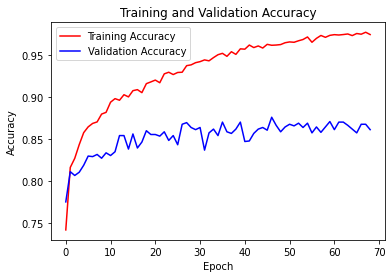

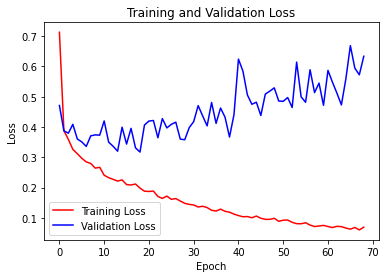

In [15]:
# Plot the loss and accuracy of the model over the training and validation data 
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('graphs/Accuracy_2.jpg')
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('graphs/Loss_2.jpg')

plt.show()

- Evaluate and compare:

In [17]:
test_loss, test_acc = model.evaluate(test_generator, steps=None, verbose=1)

49/49 [==============================] - 292s 6s/step - loss: 0.3175 - accuracy: 0.8561


In [20]:
model3 = load_model('./resnet152v2/attentions_resnet152v2_2.h5')

In [21]:
test_generator.reset()
test_loss, test_acc = model3.evaluate(test_generator, steps=None, verbose=1)

49/49 [==============================] - 261s 5s/step - loss: 0.5297 - accuracy: 0.8459


- I will use *model4* below.

In [62]:
model4 = load_model('./resnet152v2/model2')
test_generator.reset()
test_loss, test_acc = model4.evaluate(test_generator, steps=None, verbose=1)

49/49 [==============================] - 378s 8s/step - loss: 0.3175 - accuracy: 0.8561


<p><a name="Glimpse"></a></p>

## A Glimpse into the CNN
Let's see what the CNN sees:

In [23]:
import os
CTEST_PATH = f'{DATA_PATH}/test_combined/'
test_images  = os.listdir(CTEST_PATH)

In [60]:
def preprocess_image(img_path, img_size=(224,224)):
    """
    Used to preprocess a sample image from the test dataset.
    
    Parameters:
    img_path: The file path to the sample image.
    img_size: The size the sample image will be resized to.
    
    Return:
    numpy.ndarray: The multidimensional array representation of the sample image.
    """
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    import numpy as np
    img = load_img(img_path, target_size=img_size)
    img_tensor = img_to_array(img) 
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    return img_tensor

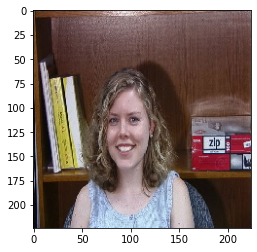

In [30]:
img_tensor = preprocess_image(CTEST_PATH + test_images[7])
plt.imshow(img_tensor[0])
plt.show()

In [33]:
# Extracts the outputs of each layer:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [34]:
# There are 569 output layers in the model.
# Thus, this model will have 1 input and 569 outputs.
len(layer_outputs)

569

In [35]:
activations = activation_model.predict(img_tensor)

In [37]:
first_layer_act = activations[0]

In [39]:
first_layer_act.shape

(1, 224, 224, 3)

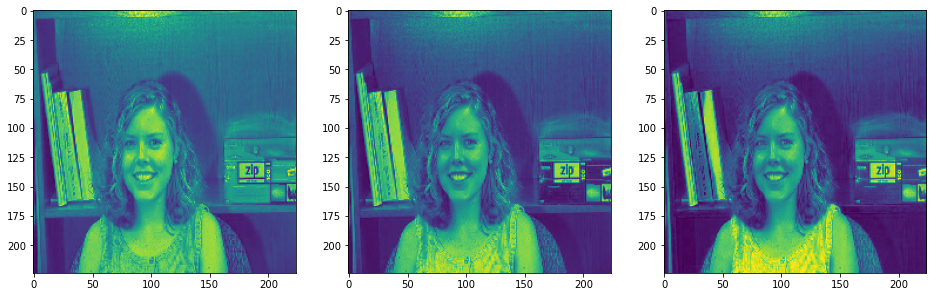

In [43]:
# Visualizing the 3 channels in the first convolutional layer of the model. 
plt.figure(figsize=(16, 12))
for i in range(first_layer_act.shape[-1]):
    plt.subplot(1,first_layer_act.shape[-1],i+1)
    plt.imshow(first_layer_act[0, :, :, i])

- One can go on to visualize the channels in each layer.

<p><a name="Video Classification"></a></p>

## Video Classification

In [76]:
import cv2 as cv
import numpy as np

VIDEO_NAME = "Example1.mp4"
VIDEO_IN = "videos/in/"
VIDEO_OUT = "videos/out/"

frame_width, frame_height = None, None

classes = ['ATTENTIVE', 'NOT ATTENTIVE']

In [80]:
# Capturing videoclip or livestream
capturing = VIDEO_IN+VIDEO_NAME # videoclip
capturing = 0 # livestream; webcam

cap = cv.VideoCapture(capturing)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
    
writer = None

In [81]:
# Loop over frames from the video stream
while True:
    # Capture frame-by-frame
    is_present, frame = cap.read()

    # If is_present is false, frame was read incorrectly or we have 
    # reached the end of the video
    if not is_present:
        print("Can't receive frame (stream end?). Exiting ...")
        break
        
    # Get frame dimensions if empty
    if frame_width is None or frame_height is None:
        frame_width, frame_height = frame.shape[:2]
        
    # Operations on the frame: Convert, Resize, Rescale
    output = frame.copy()
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    frame = cv.resize(frame, (224, 224)).astype("float32")
    frame /= 255
    
    # Label the current frame
    percent_pred = model4.predict(np.expand_dims(frame, axis=0))[0]
    percent_pred = float(*percent_pred)*100
    preds = 0 if percent_pred < 99 else 1

    label = classes[preds]    

    # Write the label on the output frame
    text = f"{label}: {percent_pred}%"
    org = (35, 50)
    font = cv.FONT_HERSHEY_DUPLEX
    fontScale = 1.25
    color = (0, 255, 0)
    thickness = 3
    cv.putText(output, text, org, font, fontScale, color, thickness)
    
    # Check if videowriter is None
    if writer is None:
        # Define the codec and create VideoWriter object
        fourcc = cv.VideoWriter_fourcc(*"DIVX")
        writer = cv.VideoWriter(VIDEO_OUT+VIDEO_NAME, fourcc, 30,
            (frame_width, frame_height), True)
        
    # Write output frame to disk
    writer.write(output)
    
    # Show output images
    cv.imshow("Output", output)
    
    # Break loop when 'q' is pressed
    if cv.waitKey(1) & 0xFF == ord("q"):
        break
        
# Rrelease the file pointers
cap.release()
writer.release()

# Close all windows
cv.destroyAllWindows()

<p><a name="Results"></a></p>

## Results

<img align="left" src="notebook_pics/far_poor.png">
Initially, the model showed poor accuracy when I was sitting a normal distance away from the screen.

However the accuracy improved when I got closer:
<p float="left">
  <img src="notebook_pics/close_a_good.png"/>
  <img src="notebook_pics/close_na_good1.png"/>
  <img src="notebook_pics/close_na_good2.png"/>
</p>

SO, I decided to adjust how the model classifies images, as seen in the code above, to lead to more accurate labeling regardless of distance. I also tested it with glasses and letting my hair down.

<p float="left">
  <img src="notebook_pics/far_a_good_h.png"/>
  <img src="notebook_pics/far_a_good_hg.png"/>
  <img src="notebook_pics/far_na_good_hg.png"/>
</p>

Unfortunately, the model didn't do as good of a job classifying attentiveness based on eye movement compared to head movement. Much of that is due to the poor job I did of labeling the data. I will **NOT** be going through those images again so perhaps I'll pay an intern to do that for me next time around.